In [1]:
! pip install datasets #설치 
! pip install transformers
! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 36.6 MB/s 
     |████████████████████████████████| 115 kB 88.5 MB/s 
     |████████████████████████████████| 163 kB 10.5 MB/s 
     |████████████████████████████████| 212 kB 95.9 MB/s 
     |████████████████████████████████| 127 kB 91.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 10.4 MB/s 
     |████████████████████████████████| 7.6 MB 80.7 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following package was automatically ins

# Data Preparing
1. data load

2. data preprocessing

    -형태소 분석

    -tokenizing
# Data Load
데이터를 로드하고, parsing 해서 필요한 데이터만 뽑아주는 모듈 KoMRC

In [2]:
from typing import List, Tuple, Dict, Any
import json
import numpy as np
import random

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]], mode=None): #, tokenizer=None):
        self._data = data
        self._indices = indices 
        self._preprocessed_data = None

    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1, seed=42, mode='mecab'): #, tokenizer=None):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices, mode=mode), cls(dataset._data, eval_indices, mode=mode)#, tokenizer=tokenizer)

#-----------------------------------------------------------------------------------

    def __getitem__(self, slices):   # index 대신 slice?
        if not self._preprocessed_data :
          self._preprocessed_data = self.__parse_rawdata(self._indices)


        if isinstance(slices, (int, np.int64)):
          # row 
          return {
              'guid': self._preprocessed_data['guid'][slices],
              'context': self._preprocessed_data['context'][slices],
              'answers': self._preprocessed_data['answers'][slices],
              'question': self._preprocessed_data['question'][slices]
          }
        elif isinstance(slices, str):
          return self._preprocessed_data[slices]
        elif isinstance(slices, slice):
          return {
              'guid': [self._preprocessed_data['guid'][i] for i in range(slices.start, slices.stop)],
              'context': [self._preprocessed_data['context'][i] for i in range(slices.start, slices.stop)],
              'answers': [self._preprocessed_data['answers'][i] for i in range(slices.start, slices.stop)],
              'question': [self._preprocessed_data['question'][i] for i in range(slices.start, slices.stop)]
          }
        raise ValueError(f'unhanled slices : {slices}, type={type(slices)}')


    def __parse_rawdata(self, indices) -> dict:

        _indices = {'question':[], 'answers':[], 
                    'context':[], 'guid':[]}

        for index, indice in enumerate(indices):
          d_id, p_id, q_id = indice
          paragraph = self._data['data'][d_id]['paragraphs'][p_id]

          qa = paragraph['qas'][q_id]
          _indices['guid'].append(qa['guid'])

          _indices['question'].append(qa['question'])
          _indices['answers'].append(qa['answers']) 
          _indices['context'].append(paragraph['context'])

        print(len(_indices['question']))
        return _indices


    def __len__(self) -> int:
        return len(self._indices)

In [3]:
# 데이터 위치 (저장하신 위치에 따라 바꿔주세요)
train_file = '/content/train.json'
test_file = '/content/test.json'
dataset = KoMRC.load(train_file)
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))

print(dev_dataset[0])
print(dev_dataset[0]['answers'])
print(dev_dataset[0]['context'].split('.')[0])
print(dev_dataset['answers'])
print(len(dev_dataset['answers']))
print(dev_dataset['question'])
print(len(dev_dataset['question']))
print(dev_dataset[0:10])

Number of Train Samples: 10834
Number of Dev Samples: 1203
1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등

In [4]:
# Tokenizer load 
from transformers import AutoTokenizer, AutoModel, AutoConfig

def load_tokenizer(model_id, test_sentence):
  tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
  return tokenizer

In [5]:
#학습된 모델 불러오기

sentence = '위메프의 배달∙픽업 서비스 위메프오가 23~25일 3일간 ‘BBQ 50% 페이백’ 이벤트를 진행한다고 23일 밝혔다'

#hf_model_id = 'kykim/electra-kor-base'
#tokenizer = load_tokenizer(hf_model_id, sentence)

# hf_model_id = 'monologg/kobert'
# tokenizer = load_tokenizer(hf_model_id, sentence)


hf_model_id = 'kykim/bert-kor-base'
tokenizer = load_tokenizer(hf_model_id, sentence)


#hf_model_id = 'Jinhwan/krelectra-base-mecab'
#tokenizer = load_tokenizer(hf_model_id, sentence)

# hf_model_id = 'monologg/kobigbird-bert-base'
# #https://github.com/monologg/KoBigBird
config = AutoConfig.from_pretrained(hf_model_id, max_position_embeddings=1024)
model = AutoModel.from_pretrained(hf_model_id)

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
print(hf_model_id)
print(tokenizer) 
question = '무슨 이벤트를 하나?'
aa =tokenizer(question, sentence, return_offsets_mapping=True)
print(aa)
print(tokenizer.unk_token_id)
print(tokenizer.cls_token_id)
print(tokenizer.sep_token_id)

# answer (16,) => 7,8
# context position (
print(aa.offset_mapping)
print(aa['input_ids'])

kykim/bert-kor-base
PreTrainedTokenizerFast(name_or_path='kykim/bert-kor-base', vocab_size=42000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
{'input_ids': [2, 15440, 21346, 14023, 2033, 3, 5842, 8593, 21573, 1, 15549, 5842, 8593, 8247, 24677, 15292, 2070, 20085, 16445, 8154, 1, 23483, 8671, 14654, 2008, 20643, 8326, 1, 21346, 28630, 8014, 20506, 14875, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 2), (3, 7), (8, 10), (10, 11), (0, 0), (0, 1), (1, 2), (2, 4), (5, 10), (11, 14), (15, 16), (16, 17), (17, 18), (18, 20), (21, 23), (23, 24), (24, 27), (28, 30), (30, 31), (32, 33), (33, 35), (35, 36)

In [7]:
from tqdm import tqdm 
class TKIndexerWrappedDataset:
    def __init__(self, dataset: KoMRC, tokenizer) -> None:
        self._indexer = tokenizer
        self._dataset = self._sample2ids_with_tk(dataset)

    def __len__(self) -> int:
        return len(self._dataset['input_ids'])


    def _sample2ids_with_tk(self, sample):
      tokenizer = self._indexer

      # return_offsets_mapping
      tokenized = tokenizer(sample['question'], 
                            sample['context'],
                            return_overflowing_tokens=True, 
                            return_offsets_mapping=True, 
                            # stride = 128,
                            return_tensors = 'pt',
                            max_length=512, 
                            truncation='only_second', 
                            padding='max_length')
      offset_map = tokenized.pop('offset_mapping')
      overflow_map = tokenized.pop('overflow_to_sample_mapping')
      tokenized['start'] = []
      tokenized['end'] = []
      tokenized['guid'] = []
      cls_id = tokenizer.cls_token_id

      for i, offsets in enumerate(tqdm(offset_map)):
        input_ids = tokenized['input_ids'][i]
        cls_index = input_ids.tolist().index(cls_id)
        seq_ids = tokenized.sequence_ids(i)

        # check
        example_idx = overflow_map[i]
        answers = sample['answers'][example_idx]
        guid = sample['guid'][example_idx]
        tokenized['guid'].append(guid)

        # 
        if not answers :
          continue 

        ans_start = answers[0]['answer_start']
        ans_end = answers[0]['answer_start'] + len(answers[0]['text'])

        # question, context 분리 
        ans_token_start = 0 
        while seq_ids[ans_token_start] != 1 :
          ans_token_start += 1 

        ans_token_end = len(input_ids) - 1
        while seq_ids[ans_token_end] != 1 :
          ans_token_end -= 1 

        if not (offsets[ans_token_start][0] <= ans_start and offsets[ans_token_end][1] >= ans_end):
          tokenized['start'].append(cls_index)
          tokenized['end'].append(cls_index)      
        else : 
          while (ans_token_start < len(offsets) 
          and offsets[ans_token_start][0] <= ans_start): 
            ans_token_start += 1 
          
          while offsets[ans_token_end][1] >= ans_end:
            ans_token_end -= 1 

          tokenized['start'].append(ans_token_start)
          tokenized['end'].append(ans_token_end)        
      return tokenized
      
    
    def __getitem__(self, slices) -> Any:

        if isinstance(slices, (int, np.int64)):
          # row 
          return {
              'input_ids': self._dataset['input_ids'][slices],
              'token_type_ids': self._dataset['token_type_ids'][slices],
              'attention_mask': self._dataset['attention_mask'][slices],
              'start': self._dataset['start'][slices] if len(self._dataset['start']) > slices else None,
              'end': self._dataset['end'][slices] if len(self._dataset['end']) > slices else None,
              'guid': self._dataset['guid'][slices]
          }
        elif isinstance(slices, str):
          return self._dataset[slices]
        elif isinstance(slices, slice):
          return {
              'input_ids': [self._dataset['input_ids'][i] for i in range(slices.start, slices.stop)],
              'token_type_ids': [self._dataset['token_type_ids'][i] for i in range(slices.start, slices.stop)],
              'attention_mask': [self._dataset['attention_mask'][i] for i in range(slices.start, slices.stop)],
              'guid': [self._dataset['guid'][i] for i in range(slices.start, slices.stop)],
              'start': [self._dataset['start'][i] for i in range(slices.start, slices.stop)],
              'end': [self._dataset['end'][i] for i in range(slices.start, slices.stop)]
          }
        raise ValueError(f'unhanled slices : {slices}, type={type(slices)}')

        return sample

In [12]:
# train,dev data 불러온 모델에 적용
indexed_train_dataset = TKIndexerWrappedDataset(train_dataset, tokenizer)
indexed_dev_dataset = TKIndexerWrappedDataset(dev_dataset, tokenizer)
print(f'\nlen origin train_dataset : {len(train_dataset)}')
print(f'len indexed_train_dataset : {len(indexed_train_dataset)}')
sample = indexed_dev_dataset[0]
print(sample['input_ids'])

100%|██████████| 1578/1578 [00:03<00:00, 466.08it/s]


len origin train_dataset : 10834
len indexed_train_dataset : 14362
tensor([    2,  5862,  8597,  8250, 32285, 15439,  8112, 21650,  8018,  5525,
        39620, 23877, 14032, 38250, 14508, 14674,  2033,     3, 15080, 15815,
        21650, 14331, 16376, 34116,  8109,  4983, 16836, 24675,  5691,  8358,
         8008, 22738,  5525, 39620, 32085, 34431,  2016, 16809,  8099,  8719,
        22578, 18397,     1, 21601, 19593,  8017,  2014, 21303,  8099,  8719,
         8017, 14706,     1,  7974,  8680,     1, 18397,  8017, 14475, 33165,
            1, 24169, 16040, 31609,  8143,     1,  2010, 14801,  2070, 19472,
        15169,  8054, 18048,  8246, 19593, 38125,  3137, 38125,  2014, 20085,
         2070, 15686, 16856,  8066,  4956,  8007,  8201, 19602,  8719,  8139,
        28828,  8829,  8020,  8222,  8448, 38125,  2011,  2014, 21650, 22578,
        13970, 17020,  8289,  7974,  8680, 14331, 15034,     1, 20570, 20723,
         8013,     1,  2010, 20521,  2070, 15686, 21363,  8066, 15169,  80

# Data 준비
Collator : 데이터를 batch에 맞게 자르고 묶어주고, 준비하는 모듈 DataLoader : 데이터를 iterative (돌아가면서 훈련할 수 있게) Load하는 모듈

In [13]:
import torch
from torch.nn.utils.rnn import pad_sequence

class Collator:
    def __init__(self, indexer) -> None:
        self._indexer = indexer

    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {
            key: [sample[key] for sample in samples]
            for key in samples[0]
        }

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence(
                [torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                batch_first=True, padding_value=self._indexer.pad_token_id
            )

        return samples

In [14]:
from torch.utils.data import DataLoader

batch_size = 64
#num_workers = core num
accumulation = 4 # 메모리를 아끼기 위하여 Gradient accumulation을 해보자
collator = Collator(tokenizer)
train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size//accumulation, shuffle=True, collate_fn=collator, num_workers=2)
dev_loader = DataLoader(indexed_dev_dataset, batch_size=batch_size//accumulation, shuffle=False, collate_fn=collator, num_workers=2)

In [15]:
batch = next(iter(dev_loader))
print(batch['input_ids'].shape)
print(list(batch.keys()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([16, 512])
['input_ids', 'token_type_ids', 'attention_mask', 'start', 'end', 'guid']


In [16]:
print(len(train_loader))
print(len(indexed_train_dataset))
print(len(indexed_train_dataset)/16)

898
14362
897.625


# 본격적으로 훈련하기
1.모델 hyperparameter 정하기

2.Training

In [27]:
!pip install transformers
import torch.nn as nn

from transformers.models.bert.modeling_bert import (
    BertModel,
    BertPreTrainedModel
)
from transformers import AutoModel
## Simple Version for Bert QA: https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForQuestionAnswering.forward
class BertForQuestionAnswering(nn.Module):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config, hf_model_id):
        # super().__init__(config)
        # self.bert = BertModel(config, add_pooling_layer=False)
        # self.start_linear = nn.Linear(config.hidden_size, 1)
        # self.end_linear = nn.Linear(config.hidden_size, 1)
        # self.init_weights()

        super().__init__()
        self.bert = AutoModel.from_pretrained(hf_model_id)
        self.start_linear = nn.Linear(self.bert.config.hidden_size, 1)
        self.end_linear = nn.Linear(self.bert.config.hidden_size, 1)


    def forward(
        self, input_ids, attention_mask, token_type_ids
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
        end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

        return start_logits, end_logits

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import torch
from transformers import BertConfig


print(f'Encoder model to use : {hf_model_id}')
model = BertForQuestionAnswering({}, hf_model_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Encoder model to use : kykim/bert-kor-base


Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
# device set
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.cuda()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [32]:
#######################################################################
from torch.utils.data import RandomSampler, DataLoader, Subset
import numpy as np 

num_train_samples = 16
sample_ds = Subset(indexed_train_dataset, np.arange(num_train_samples))
sample_sampler = RandomSampler(sample_ds)
sample_dl = DataLoader(sample_ds, collate_fn=collator, sampler=sample_sampler, batch_size=4)
next(iter(sample_dl))

num_dev_samples = 2
sample_ds_dev = Subset(indexed_dev_dataset, np.arange(num_dev_samples))
sample_sampler_dev = RandomSampler(sample_ds_dev)
sample_dl_dev = DataLoader(sample_ds_dev, collate_fn=collator, sampler=sample_sampler_dev, batch_size=4)
next(iter(sample_dl_dev))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'input_ids': tensor([[   2, 5862, 8597,  ...,    0,    0,    0],
         [   2, 5862, 8597,  ..., 5970, 8472,    3]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 1, 1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'start': tensor([  0, 150]),
 'end': tensor([  0, 154]),
 'guid': ['844e22ab28924c1697d5ac28801b34c1',
  '844e22ab28924c1697d5ac28801b34c1']}

In [33]:
import os
from statistics import mean

import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
print(f'device : {device}')
os.makedirs('dump', exist_ok=True)
train_losses = []
dev_losses = []

step = 0


for epoch in range(1, 31):
    print("Epoch", epoch)
    # Training
    running_loss = 0.
    losses = []
    progress_bar = tqdm(sample_dl, desc='Train')
    for batch in progress_bar:
        del batch['guid'] #, batch['context'], batch['question'], batch['position']
        # batch = {key: value.cuda() for key, value in batch.items()}
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['token_type_ids'] = batch['token_type_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['start'] = batch['start'].to(device)
        batch['end'] = batch['end'].to(device)

        start = batch.pop('start')
        end = batch.pop('end')
        
        model_output = model(**batch)
        
        try :
          start_logits, end_logits = model_output
        except Exception as e :
          print(model_output)
          raise e 
        
        try :
          print('loss')
          loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

          print(torch.argmax(start_logits, dim=1))
          print(start)
          print(f'ce1 : {F.cross_entropy(start_logits, start)}')
          print(f'ce2 : {F.cross_entropy(end_logits, end)}')

          loss.backward()
          running_loss += loss.item()
          print(f'running_loss : {running_loss}')
        except Exception as e :
          print(f'start_logits : {start_logits}')
          print(f'end_logits : {end_logits}')
          print(f'start : {start}')
          print(f'end : {end}')
          print(f'loss : {loss}')
          raise e 
        del batch, start, end, start_logits, end_logits, loss
        
        step += 1
        # if step % accumulation:
        #     continue

        clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(running_loss)
        running_loss = 0.
        progress_bar.set_description(f"Train - Loss: {losses[-1]:.3f}")

    train_losses.append(mean(losses))
    print(f"train score: {train_losses[-1]:.3f}")

    # Evaluation
    losses = []
    for batch in tqdm(sample_dl_dev, desc="Evaluation"):
        del batch['guid'] #, batch['context'], batch['question'], batch['position']
        # batch = {key: value.cuda() for key, value in batch.items()}
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['token_type_ids'] = batch['token_type_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['start'] = batch['start'].to(device)
        batch['end'] = batch['end'].to(device)

        start = batch.pop('start')
        end = batch.pop('end')
        
        with torch.no_grad():
            start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

        losses.append(loss.item())
        del batch, start, end, start_logits, end_logits, loss
    dev_losses.append(mean(losses))
    print(f"Evaluation score: {dev_losses[-1]:.3f}")

    torch.save(model, f'dump/model.{epoch}')

device : cuda
Epoch 1


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  4,   9, 453,  92], device='cuda:0')
tensor([121,   0,  24,   0], device='cuda:0')
ce1 : 6.232970714569092
ce2 : 6.467718124389648


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train - Loss: 12.701:  25%|██▌       | 1/4 [00:00<00:01,  2.30it/s]

running_loss : 12.700689315795898
loss
tensor([264, 420,  16, 210], device='cuda:0')
tensor([ 23, 484,  75, 351], device='cuda:0')
ce1 : 5.721076011657715
ce2 : 5.846167087554932


Train - Loss: 11.567:  50%|█████     | 2/4 [00:00<00:00,  2.49it/s]

running_loss : 11.567243576049805
loss
tensor([ 71, 314,   1, 200], device='cuda:0')
tensor([288,  44,   0,  69], device='cuda:0')
ce1 : 5.991205215454102
ce2 : 6.037653923034668


Train - Loss: 12.029:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

running_loss : 12.02885913848877
loss
tensor([262, 482,   5, 276], device='cuda:0')
tensor([446, 328,   0, 173], device='cuda:0')
ce1 : 6.290277481079102
ce2 : 6.373520851135254


Train - Loss: 12.664: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


running_loss : 12.663798332214355
train score: 12.240


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]

Evaluation score: 10.574


Epoch 2


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([188,   2,   0,  44], device='cuda:0')
tensor([328,   0,   0,  44], device='cuda:0')
ce1 : 4.571890354156494
ce2 : 4.488036632537842


Train - Loss: 9.060:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

running_loss : 9.059926986694336
loss
tensor([  0,  19, 262, 121], device='cuda:0')
tensor([  0,   0, 446, 121], device='cuda:0')
ce1 : 3.5929384231567383
ce2 : 3.710402488708496


Train - Loss: 7.303:  50%|█████     | 2/4 [00:00<00:00,  2.68it/s]

running_loss : 7.303340911865234
loss
tensor([288,  23, 351,   2], device='cuda:0')
tensor([288,  23, 351,  24], device='cuda:0')
ce1 : 3.5913283824920654
ce2 : 3.5994322299957275


Train - Loss: 7.191:  75%|███████▌  | 3/4 [00:01<00:00,  2.58it/s]

running_loss : 7.190760612487793
loss
tensor([ 69, 122, 484, 230], device='cuda:0')
tensor([ 69,  75, 484, 173], device='cuda:0')
ce1 : 3.676973581314087
ce2 : 3.4049580097198486


Train - Loss: 7.082: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


running_loss : 7.0819315910339355
train score: 7.659


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]

Evaluation score: 8.808


Epoch 3


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([262,   0, 173,  69], device='cuda:0')
tensor([446,   0, 173,  69], device='cuda:0')
ce1 : 3.119781255722046
ce2 : 3.115370512008667


Train - Loss: 6.235:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

running_loss : 6.235151767730713
loss
tensor([ 44, 328, 484,   0], device='cuda:0')
tensor([ 44, 328, 484,   0], device='cuda:0')
ce1 : 1.8464653491973877
ce2 : 1.8028099536895752


Train - Loss: 3.649:  50%|█████     | 2/4 [00:00<00:00,  2.68it/s]

running_loss : 3.649275302886963
loss
tensor([121,   0,  24, 288], device='cuda:0')
tensor([121,   0,  24, 288], device='cuda:0')
ce1 : 1.430064082145691
ce2 : 1.4765620231628418


Train - Loss: 2.907:  75%|███████▌  | 3/4 [00:01<00:00,  2.59it/s]

running_loss : 2.9066262245178223
loss
tensor([  0,  75,  23, 351], device='cuda:0')
tensor([  0,  75,  23, 351], device='cuda:0')
ce1 : 1.3020060062408447
ce2 : 1.2745482921600342


Train - Loss: 2.577: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


running_loss : 2.576554298400879
train score: 3.842


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]

Evaluation score: 7.727


Epoch 4


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([173,   0, 328, 446], device='cuda:0')
tensor([173,   0, 328, 446], device='cuda:0')
ce1 : 1.1851024627685547
ce2 : 1.5206915140151978


Train - Loss: 2.706:  25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

running_loss : 2.705793857574463
loss
tensor([ 75,   0,   0, 288], device='cuda:0')
tensor([ 75,   0,   0, 288], device='cuda:0')
ce1 : 0.3714038133621216
ce2 : 0.31894543766975403


Train - Loss: 0.690:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

running_loss : 0.6903492212295532
loss
tensor([ 23, 351,  44, 121], device='cuda:0')
tensor([ 23, 351,  44, 121], device='cuda:0')
ce1 : 0.12576964497566223
ce2 : 0.19571584463119507


Train - Loss: 0.321:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

running_loss : 0.3214854896068573
loss
tensor([  0, 484,  69,  24], device='cuda:0')
tensor([  0, 484,  69,  24], device='cuda:0')
ce1 : 0.24556851387023926
ce2 : 0.31459081172943115


Train - Loss: 0.560: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


running_loss : 0.5601593255996704
train score: 1.069


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]

Evaluation score: 7.907


Epoch 5


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 23,  69, 328,  44], device='cuda:0')
tensor([ 23,  69, 328,  44], device='cuda:0')
ce1 : 0.07574223726987839
ce2 : 0.0567752867937088


Train - Loss: 0.133:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

running_loss : 0.1325175166130066
loss
tensor([484, 351,   0,   0], device='cuda:0')
tensor([484, 351,   0,   0], device='cuda:0')
ce1 : 0.0216984860599041
ce2 : 0.024246763437986374


Train - Loss: 0.046:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

running_loss : 0.04594524949789047
loss
tensor([121,  24,   0, 173], device='cuda:0')
tensor([121,  24,   0, 173], device='cuda:0')
ce1 : 0.06536117196083069
ce2 : 0.7881587743759155


Train - Loss: 0.854:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

running_loss : 0.8535199165344238
loss
tensor([288,   0,  75, 446], device='cuda:0')
tensor([288,   0,  75, 446], device='cuda:0')
ce1 : 0.04390781745314598
ce2 : 0.04118958115577698


Train - Loss: 0.085: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


running_loss : 0.08509740233421326
train score: 0.279


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]

Evaluation score: 6.732


Epoch 6


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 44, 446,  69,  24], device='cuda:0')
tensor([ 44, 446,  69,  24], device='cuda:0')
ce1 : 0.02723061293363571
ce2 : 0.024791782721877098


Train - Loss: 0.052:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 0.05202239751815796
loss
tensor([351, 484,   0,   0], device='cuda:0')
tensor([351, 484,   0,   0], device='cuda:0')
ce1 : 0.0058105215430259705
ce2 : 0.006779422052204609


Train - Loss: 0.013:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

running_loss : 0.01258994359523058
loss
tensor([328, 121, 288, 173], device='cuda:0')
tensor([328, 121, 288, 173], device='cuda:0')
ce1 : 0.011053328402340412
ce2 : 0.52120041847229


Train - Loss: 0.532:  75%|███████▌  | 3/4 [00:01<00:00,  2.59it/s]

running_loss : 0.5322537422180176
loss
tensor([75,  0,  0, 23], device='cuda:0')
tensor([75,  0,  0, 23], device='cuda:0')
ce1 : 0.00347633333876729
ce2 : 0.00453108549118042


Train - Loss: 0.008: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


running_loss : 0.008007418364286423
train score: 0.151


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]

Evaluation score: 6.746


Epoch 7


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([23, 24,  0,  0], device='cuda:0')
tensor([23, 24,  0,  0], device='cuda:0')
ce1 : 0.004185165744274855
ce2 : 0.010275794193148613


Train - Loss: 0.014:  25%|██▌       | 1/4 [00:00<00:01,  2.74it/s]

running_loss : 0.014460960403084755
loss
tensor([  0,  75, 288, 121], device='cuda:0')
tensor([  0,  75, 288, 121], device='cuda:0')
ce1 : 0.00397625844925642
ce2 : 0.0032149087637662888


Train - Loss: 0.007:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

running_loss : 0.007191167213022709
loss
tensor([328, 173,  44, 351], device='cuda:0')
tensor([328, 173,  44, 351], device='cuda:0')
ce1 : 0.3242195248603821
ce2 : 0.1128040999174118


Train - Loss: 0.437:  75%|███████▌  | 3/4 [00:01<00:00,  2.55it/s]

running_loss : 0.4370236396789551
loss
tensor([  0, 446,  69, 484], device='cuda:0')
tensor([  0, 446,  69, 484], device='cuda:0')
ce1 : 0.00427699601277709
ce2 : 0.001987694064155221


Train - Loss: 0.006: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


running_loss : 0.006264690309762955
train score: 0.116


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]

Evaluation score: 6.351


Epoch 8


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 69,  75, 351,   0], device='cuda:0')
tensor([ 69,  75, 351,   0], device='cuda:0')
ce1 : 0.0008282119524665177
ce2 : 0.0013675997033715248


Train - Loss: 0.002:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 0.0021958115976303816
loss
tensor([ 23, 484,   0,  24], device='cuda:0')
tensor([ 23, 484,   0,  24], device='cuda:0')
ce1 : 0.000644933432340622
ce2 : 0.0005703970091417432


Train - Loss: 0.001:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.0012153304414823651
loss
tensor([ 44, 288, 446, 173], device='cuda:0')
tensor([ 44, 288, 446, 173], device='cuda:0')
ce1 : 0.016340041533112526
ce2 : 0.0676371231675148


Train - Loss: 0.084:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

running_loss : 0.08397716283798218
loss
tensor([328, 121,   0,   0], device='cuda:0')
tensor([328, 121,   0,   0], device='cuda:0')
ce1 : 0.0007962967501953244
ce2 : 0.0008262195624411106


Train - Loss: 0.002: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


running_loss : 0.001622516312636435
train score: 0.022


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]

Evaluation score: 6.239


Epoch 9


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 0, 24,  0, 44], device='cuda:0')
tensor([ 0, 24,  0, 44], device='cuda:0')
ce1 : 0.00030139542650431395
ce2 : 0.0004354120756033808


Train - Loss: 0.001:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

running_loss : 0.0007368074730038643
loss
tensor([ 23, 351,  69, 484], device='cuda:0')
tensor([ 23, 351,  69, 484], device='cuda:0')
ce1 : 0.00045401862007565796
ce2 : 0.0001891935826279223


Train - Loss: 0.001:  50%|█████     | 2/4 [00:00<00:00,  2.65it/s]

running_loss : 0.0006432122318074107
loss
tensor([173, 328, 446, 121], device='cuda:0')
tensor([173, 328, 446, 121], device='cuda:0')
ce1 : 0.0010600271634757519
ce2 : 0.004683686885982752


Train - Loss: 0.006:  75%|███████▌  | 3/4 [00:01<00:00,  2.58it/s]

running_loss : 0.005743714049458504
loss
tensor([288,   0,   0,  75], device='cuda:0')
tensor([288,   0,   0,  75], device='cuda:0')
ce1 : 0.0012791547924280167
ce2 : 0.0009137282031588256


Train - Loss: 0.002: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


running_loss : 0.002192883053794503
train score: 0.002


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]

Evaluation score: 6.658


Epoch 10


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 0,  0, 24, 69], device='cuda:0')
tensor([ 0,  0, 24, 69], device='cuda:0')
ce1 : 0.0002582032175268978
ce2 : 0.00011547665053512901


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

running_loss : 0.00037367985351011157
loss
tensor([ 44, 446, 351, 328], device='cuda:0')
tensor([ 44, 446, 351, 328], device='cuda:0')
ce1 : 0.00023206777404993773
ce2 : 0.0005561953294090927


Train - Loss: 0.001:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.0007882631034590304
loss
tensor([173,   0,   0, 288], device='cuda:0')
tensor([173,   0,   0, 288], device='cuda:0')
ce1 : 0.0006993780843913555
ce2 : 0.0007611799519509077


Train - Loss: 0.001:  75%|███████▌  | 3/4 [00:01<00:00,  2.54it/s]

running_loss : 0.0014605580363422632
loss
tensor([ 23,  75, 121, 484], device='cuda:0')
tensor([ 23,  75, 121, 484], device='cuda:0')
ce1 : 0.0004992297035641968
ce2 : 6.791690975660458e-05


Train - Loss: 0.001: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


running_loss : 0.0005671466351486742
train score: 0.001


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]

Evaluation score: 6.699


Epoch 11


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0,   0,  24, 328], device='cuda:0')
tensor([  0,   0,  24, 328], device='cuda:0')
ce1 : 0.0002450612373650074
ce2 : 0.00011404356337152421


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

running_loss : 0.0003591048007365316
loss
tensor([ 44, 484,  69,  23], device='cuda:0')
tensor([ 44, 484,  69,  23], device='cuda:0')
ce1 : 0.0002244433999294415
ce2 : 8.052209159359336e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.00030496547697111964
loss
tensor([121,   0, 173,   0], device='cuda:0')
tensor([121,   0, 173,   0], device='cuda:0')
ce1 : 0.0006481457385234535
ce2 : 0.00023239231086336076


Train - Loss: 0.001:  75%|███████▌  | 3/4 [00:01<00:00,  2.54it/s]

running_loss : 0.0008805380202829838
loss
tensor([ 75, 446, 351, 288], device='cuda:0')
tensor([ 75, 446, 351, 288], device='cuda:0')
ce1 : 8.922372944653034e-05
ce2 : 0.0002566502953413874


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


running_loss : 0.00034587402478791773
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]

Evaluation score: 6.736


Epoch 12


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([121, 446,   0,  23], device='cuda:0')
tensor([121, 446,   0,  23], device='cuda:0')
ce1 : 0.00016082719957921654
ce2 : 0.00013516774924937636


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

running_loss : 0.0002959949488285929
loss
tensor([328,  24,  75,   0], device='cuda:0')
tensor([328,  24,  75,   0], device='cuda:0')
ce1 : 0.00018707659910432994
ce2 : 0.00020545917504932731


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.00039253575960174203
loss
tensor([  0,  44, 484, 288], device='cuda:0')
tensor([  0,  44, 484, 288], device='cuda:0')
ce1 : 0.00016240922559518367
ce2 : 9.232234879164025e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

running_loss : 0.0002547315671108663
loss
tensor([  0,  69, 173, 351], device='cuda:0')
tensor([  0,  69, 173, 351], device='cuda:0')
ce1 : 0.00027605408104136586
ce2 : 0.00010862202907446772


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 0.00038467609556391835
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s]

Evaluation score: 6.806


Epoch 13


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0, 328,  24, 484], device='cuda:0')
tensor([  0, 328,  24, 484], device='cuda:0')
ce1 : 0.00018356442160438746
ce2 : 0.0001500666403444484


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.66it/s]

running_loss : 0.00033363106194883585
loss
tensor([  0,  23,   0, 288], device='cuda:0')
tensor([  0,  23,   0, 288], device='cuda:0')
ce1 : 0.00010293176455888897
ce2 : 6.833354564150795e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.0001712653029244393
loss
tensor([ 69, 351, 121, 446], device='cuda:0')
tensor([ 69, 351, 121, 446], device='cuda:0')
ce1 : 8.710782276466489e-05
ce2 : 0.00010522604134166613


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.54it/s]

running_loss : 0.0001923338568303734
loss
tensor([ 75, 173,  44,   0], device='cuda:0')
tensor([ 75, 173,  44,   0], device='cuda:0')
ce1 : 0.0001913585583679378
ce2 : 0.00011613049719016999


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


running_loss : 0.000307489070110023
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]

Evaluation score: 6.884


Epoch 14


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([351,  44,   0, 288], device='cuda:0')
tensor([351,  44,   0, 288], device='cuda:0')
ce1 : 9.13095282157883e-05
ce2 : 8.850870653986931e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

running_loss : 0.0001798182347556576
loss
tensor([  0,   0,  24, 446], device='cuda:0')
tensor([  0,   0,  24, 446], device='cuda:0')
ce1 : 0.00010215678048552945
ce2 : 0.00010415119322715327


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 0.00020630797371268272
loss
tensor([ 75, 484,  23, 121], device='cuda:0')
tensor([ 75, 484,  23, 121], device='cuda:0')
ce1 : 6.842333823442459e-05
ce2 : 9.083143231691793e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

running_loss : 0.0001592547632753849
loss
tensor([328, 173,  69,   0], device='cuda:0')
tensor([328, 173,  69,   0], device='cuda:0')
ce1 : 0.00016455200966447592
ce2 : 8.359145431313664e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 0.0002481434494256973
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]

Evaluation score: 6.942


Epoch 15


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0,  24,  75, 351], device='cuda:0')
tensor([  0,  24,  75, 351], device='cuda:0')
ce1 : 5.569847780861892e-05
ce2 : 8.779247582424432e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

running_loss : 0.00014349094999488443
loss
tensor([  0, 121, 484,   0], device='cuda:0')
tensor([  0, 121, 484,   0], device='cuda:0')
ce1 : 8.061187691055238e-05
ce2 : 9.610753477318212e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.00017671941895969212
loss
tensor([ 23, 446,  69, 328], device='cuda:0')
tensor([ 23, 446,  69, 328], device='cuda:0')
ce1 : 9.101151954382658e-05
ce2 : 5.936413799645379e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

running_loss : 0.00015037565026432276
loss
tensor([  0,  44, 173, 288], device='cuda:0')
tensor([  0,  44, 173, 288], device='cuda:0')
ce1 : 0.00012435653479769826
ce2 : 7.033028668956831e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 0.00019468681421130896
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]

Evaluation score: 6.974


Epoch 16


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([446,  24,   0,  44], device='cuda:0')
tensor([446,  24,   0,  44], device='cuda:0')
ce1 : 7.444337825290859e-05
ce2 : 4.950034053763375e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 0.00012394372606649995
loss
tensor([173, 484,   0, 121], device='cuda:0')
tensor([173, 484,   0, 121], device='cuda:0')
ce1 : 8.573667582822964e-05
ce2 : 9.187602699967101e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

running_loss : 0.00017761270282790065
loss
tensor([351,  23, 288,   0], device='cuda:0')
tensor([351,  23, 288,   0], device='cuda:0')
ce1 : 7.637988164788112e-05
ce2 : 4.336121855885722e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.55it/s]

running_loss : 0.00011974110384471714
loss
tensor([ 75,  69,   0, 328], device='cuda:0')
tensor([ 75,  69,   0, 328], device='cuda:0')
ce1 : 6.964488420635462e-05
ce2 : 8.23402515379712e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


running_loss : 0.00015198513574432582
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]

Evaluation score: 6.979


Epoch 17


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 24, 288,  75,   0], device='cuda:0')
tensor([ 24, 288,  75,   0], device='cuda:0')
ce1 : 7.152242324082181e-05
ce2 : 6.815527740400285e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 0.00013967769336886704
loss
tensor([  0, 484, 351, 173], device='cuda:0')
tensor([  0, 484, 351, 173], device='cuda:0')
ce1 : 6.171811401145533e-05
ce2 : 7.295265095308423e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 0.00013467075768858194
loss
tensor([328,  23,  69,  44], device='cuda:0')
tensor([328,  23,  69,  44], device='cuda:0')
ce1 : 6.708249566145241e-05
ce2 : 5.084124131826684e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

running_loss : 0.00011792373697971925
loss
tensor([  0, 121,   0, 446], device='cuda:0')
tensor([  0, 121,   0, 446], device='cuda:0')
ce1 : 6.735092756571248e-05
ce2 : 5.6473640142939985e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 0.00012382457498461008
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]

Evaluation score: 6.974


Epoch 18


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([44,  0,  0, 75], device='cuda:0')
tensor([44,  0,  0, 75], device='cuda:0')
ce1 : 4.589436139212921e-05
ce2 : 5.504311411641538e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

running_loss : 0.0001009374755085446
loss
tensor([121, 484, 288,  24], device='cuda:0')
tensor([121, 484, 288,  24], device='cuda:0')
ce1 : 6.562229827977717e-05
ce2 : 5.4745283705415204e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 0.00012036757834721357
loss
tensor([351,  23, 328,   0], device='cuda:0')
tensor([351,  23, 328,   0], device='cuda:0')
ce1 : 5.6980141380336136e-05
ce2 : 5.2629271522164345e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

running_loss : 0.00010960941290250048
loss
tensor([446,  69, 173,   0], device='cuda:0')
tensor([446,  69, 173,   0], device='cuda:0')
ce1 : 6.97349023539573e-05
ce2 : 6.41913793515414e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 0.0001339262817054987
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]

Evaluation score: 6.959


Epoch 19


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([351,   0,   0, 173], device='cuda:0')
tensor([351,   0,   0, 173], device='cuda:0')
ce1 : 5.4536543757421896e-05
ce2 : 6.204569945111871e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 0.00011658224684651941
loss
tensor([484, 121,  75,  24], device='cuda:0')
tensor([484, 121,  75,  24], device='cuda:0')
ce1 : 4.19904499722179e-05
ce2 : 5.861939280293882e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.61it/s]

running_loss : 0.00010060984641313553
loss
tensor([23, 44, 69,  0], device='cuda:0')
tensor([23, 44, 69,  0], device='cuda:0')
ce1 : 4.649052789318375e-05
ce2 : 4.598375744535588e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

running_loss : 9.247428533853963e-05
loss
tensor([288,   0, 446, 328], device='cuda:0')
tensor([288,   0, 446, 328], device='cuda:0')
ce1 : 7.506917609134689e-05
ce2 : 4.327192436903715e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 0.00011834110046038404
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]

Evaluation score: 6.941


Epoch 20


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0,   0, 121, 288], device='cuda:0')
tensor([  0,   0, 121, 288], device='cuda:0')
ce1 : 5.72186618228443e-05
ce2 : 4.574534614221193e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

running_loss : 0.00010296401160303503
loss
tensor([ 24, 351, 484,   0], device='cuda:0')
tensor([ 24, 351, 484,   0], device='cuda:0')
ce1 : 4.6013643441256136e-05
ce2 : 3.9844864659244195e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 8.585851173847914e-05
loss
tensor([446,   0, 328,  23], device='cuda:0')
tensor([446,   0, 328,  23], device='cuda:0')
ce1 : 5.6950510042952374e-05
ce2 : 4.061959043610841e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

running_loss : 9.757009684108198e-05
loss
tensor([173,  44,  69,  75], device='cuda:0')
tensor([173,  44,  69,  75], device='cuda:0')
ce1 : 4.2795039917109534e-05
ce2 : 6.776776717742905e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 0.00011056280345655978
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]

Evaluation score: 6.915


Epoch 21


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0, 351,  23, 173], device='cuda:0')
tensor([  0, 351,  23, 173], device='cuda:0')
ce1 : 4.33613131463062e-05
ce2 : 4.714534225058742e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 9.050665539689362e-05
loss
tensor([121,  24,   0,   0], device='cuda:0')
tensor([121,  24,   0,   0], device='cuda:0')
ce1 : 5.03348492202349e-05
ce2 : 3.942762850783765e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 8.976247772807255e-05
loss
tensor([ 75,   0,  44, 328], device='cuda:0')
tensor([ 75,   0,  44, 328], device='cuda:0')
ce1 : 4.434468428371474e-05
ce2 : 5.4477139201480895e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

running_loss : 9.882182348519564e-05
loss
tensor([446, 484,  69, 288], device='cuda:0')
tensor([446, 484,  69, 288], device='cuda:0')
ce1 : 5.185457848710939e-05
ce2 : 4.2348190618213266e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


running_loss : 9.420276910532266e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s]

Evaluation score: 6.889


Epoch 22


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 44, 328,  75, 173], device='cuda:0')
tensor([ 44, 328,  75, 173], device='cuda:0')
ce1 : 4.759295188705437e-05
ce2 : 6.487722566816956e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.65it/s]

running_loss : 0.00011247018119320273
loss
tensor([484,   0,   0, 288], device='cuda:0')
tensor([484,   0,   0, 288], device='cuda:0')
ce1 : 4.756326234200969e-05
ce2 : 3.0040237106732093e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 7.760350126773119e-05
loss
tensor([ 23,  69, 446,   0], device='cuda:0')
tensor([ 23,  69, 446,   0], device='cuda:0')
ce1 : 4.354021075414494e-05
ce2 : 3.939777525374666e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

running_loss : 8.29379860078916e-05
loss
tensor([121,  24,   0, 351], device='cuda:0')
tensor([121,  24,   0, 351], device='cuda:0')
ce1 : 4.1275332478107885e-05
ce2 : 3.924886914319359e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


running_loss : 8.052420162130147e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]

Evaluation score: 6.865


Epoch 23


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([484, 121,   0,   0], device='cuda:0')
tensor([484, 121,   0,   0], device='cuda:0')
ce1 : 4.3659438233589754e-05
ce2 : 4.187130616628565e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

running_loss : 8.55307443998754e-05
loss
tensor([24, 69, 75,  0], device='cuda:0')
tensor([24, 69, 75,  0], device='cuda:0')
ce1 : 3.5851488064508885e-05
ce2 : 4.056012403452769e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 7.641161209903657e-05
loss
tensor([446,  23, 351,   0], device='cuda:0')
tensor([446,  23, 351,   0], device='cuda:0')
ce1 : 3.558329990482889e-05
ce2 : 2.527200740587432e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

running_loss : 6.0855309129692614e-05
loss
tensor([328, 288,  44, 173], device='cuda:0')
tensor([328, 288,  44, 173], device='cuda:0')
ce1 : 5.5609518312849104e-05
ce2 : 5.656290159095079e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


running_loss : 0.00011217241990379989
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s]

Evaluation score: 6.849


Epoch 24


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 23,   0,   0, 288], device='cuda:0')
tensor([ 23,   0,   0, 288], device='cuda:0')
ce1 : 4.3271968024782836e-05
ce2 : 2.7179308744962327e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.35it/s]

running_loss : 7.045127858873457e-05
loss
tensor([ 69, 484, 328,  44], device='cuda:0')
tensor([ 69, 484, 328,  44], device='cuda:0')
ce1 : 4.166271537542343e-05
ce2 : 4.24971804022789e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.48it/s]

running_loss : 8.415989577770233e-05
loss
tensor([  0, 173,   0, 121], device='cuda:0')
tensor([  0, 173,   0, 121], device='cuda:0')
ce1 : 4.491103391046636e-05
ce2 : 5.182451423024759e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.47it/s]

running_loss : 9.673554450273514e-05
loss
tensor([446,  24, 351,  75], device='cuda:0')
tensor([446,  24, 351,  75], device='cuda:0')
ce1 : 3.4450815292075276e-05
ce2 : 3.483830369077623e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


running_loss : 6.92891189828515e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.12it/s]

Evaluation score: 6.830


Epoch 25


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 24,   0, 173,   0], device='cuda:0')
tensor([ 24,   0, 173,   0], device='cuda:0')
ce1 : 4.431501656654291e-05
ce2 : 4.824841016670689e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 9.256342309527099e-05
loss
tensor([446, 328,  44, 484], device='cuda:0')
tensor([446, 328,  44, 484], device='cuda:0')
ce1 : 4.3063380871899426e-05
ce2 : 3.883164390572347e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.61it/s]

running_loss : 8.189502113964409e-05
loss
tensor([121, 288,   0,   0], device='cuda:0')
tensor([121, 288,   0,   0], device='cuda:0')
ce1 : 4.3033596739405766e-05
ce2 : 3.316940274089575e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

running_loss : 7.620299584232271e-05
loss
tensor([ 69,  75,  23, 351], device='cuda:0')
tensor([ 69,  75,  23, 351], device='cuda:0')
ce1 : 2.6404493837617338e-05
ce2 : 3.063626718358137e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


running_loss : 5.7040761021198705e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]

Evaluation score: 6.818


Epoch 26


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([484, 121,  69,  44], device='cuda:0')
tensor([484, 121,  69,  44], device='cuda:0')
ce1 : 3.5762135667027906e-05
ce2 : 3.6864781577605754e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

running_loss : 7.262692088261247e-05
loss
tensor([173,  24, 328, 288], device='cuda:0')
tensor([173,  24, 328, 288], device='cuda:0')
ce1 : 5.197387872613035e-05
ce2 : 5.107965262141079e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 0.00010305353498551995
loss
tensor([ 75, 446,   0,   0], device='cuda:0')
tensor([ 75, 446,   0,   0], device='cuda:0')
ce1 : 3.2424344681203365e-05
ce2 : 3.388459299458191e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

running_loss : 6.630893767578527e-05
loss
tensor([  0, 351,   0,  23], device='cuda:0')
tensor([  0, 351,   0,  23], device='cuda:0')
ce1 : 3.0308496206998825e-05
ce2 : 2.3483935365220532e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


running_loss : 5.379243157221936e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]

Evaluation score: 6.809


Epoch 27


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0,   0, 484, 121], device='cuda:0')
tensor([  0,   0, 484, 121], device='cuda:0')
ce1 : 3.814623778453097e-05
ce2 : 3.454023681115359e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 7.268647459568456e-05
loss
tensor([ 44, 446,   0,  24], device='cuda:0')
tensor([ 44, 446,   0,  24], device='cuda:0')
ce1 : 3.474888580967672e-05
ce2 : 2.7924357709707692e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.60it/s]

running_loss : 6.267324351938441e-05
loss
tensor([288, 173, 328,   0], device='cuda:0')
tensor([288, 173, 328,   0], device='cuda:0')
ce1 : 4.714611714007333e-05
ce2 : 4.9083027988672256e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

running_loss : 9.622914512874559e-05
loss
tensor([351,  75,  69,  23], device='cuda:0')
tensor([351,  75,  69,  23], device='cuda:0')
ce1 : 2.4765411581029184e-05
ce2 : 2.8103155273129232e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


running_loss : 5.2868566854158416e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]

Evaluation score: 6.798


Epoch 28


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0, 446,   0, 121], device='cuda:0')
tensor([  0, 446,   0, 121], device='cuda:0')
ce1 : 3.507670044200495e-05
ce2 : 2.6464067559572868e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

running_loss : 6.154076982056722e-05
loss
tensor([484,  24,  44, 288], device='cuda:0')
tensor([484,  24,  44, 288], device='cuda:0')
ce1 : 3.719258165801875e-05
ce2 : 3.1172741728369147e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.61it/s]

running_loss : 6.836531974840909e-05
loss
tensor([ 69,  23,  75, 328], device='cuda:0')
tensor([ 69,  23,  75, 328], device='cuda:0')
ce1 : 3.057663707295433e-05
ce2 : 3.248394205002114e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.50it/s]

running_loss : 6.306057912297547e-05
loss
tensor([173, 351,   0,   0], device='cuda:0')
tensor([173, 351,   0,   0], device='cuda:0')
ce1 : 3.695413761306554e-05
ce2 : 4.50896768597886e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


running_loss : 8.204381447285414e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]

Evaluation score: 6.786


Epoch 29


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([484,   0, 351,   0], device='cuda:0')
tensor([484,   0, 351,   0], device='cuda:0')
ce1 : 3.0248882467276417e-05
ce2 : 2.8490550903370604e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

running_loss : 5.873943155165762e-05
loss
tensor([ 0, 44, 69,  0], device='cuda:0')
tensor([ 0, 44, 69,  0], device='cuda:0')
ce1 : 2.9772076231893152e-05
ce2 : 2.8371385269565508e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 5.814346150145866e-05
loss
tensor([ 23, 328, 121, 446], device='cuda:0')
tensor([ 23, 328, 121, 446], device='cuda:0')
ce1 : 3.746077709365636e-05
ce2 : 3.191772339050658e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

running_loss : 6.937849684618413e-05
loss
tensor([288,  24,  75, 173], device='cuda:0')
tensor([288,  24,  75, 173], device='cuda:0')
ce1 : 3.7460733437910676e-05
ce2 : 4.2616222344804555e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


running_loss : 8.007695578271523e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]

Evaluation score: 6.778


Epoch 30


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0,   0, 328, 446], device='cuda:0')
tensor([  0,   0, 328, 446], device='cuda:0')
ce1 : 3.659654612420127e-05
ce2 : 3.3824991987785324e-05


Train - Loss: 0.000:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

running_loss : 7.042153447400779e-05
loss
tensor([121,   0, 351,  75], device='cuda:0')
tensor([121,   0, 351,  75], device='cuda:0')
ce1 : 2.7119713195133954e-05
ce2 : 2.893762939493172e-05


Train - Loss: 0.000:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 5.605734259006567e-05
loss
tensor([ 23,  24,   0, 173], device='cuda:0')
tensor([ 23,  24,   0, 173], device='cuda:0')
ce1 : 3.477865539025515e-05
ce2 : 3.415259561734274e-05


Train - Loss: 0.000:  75%|███████▌  | 3/4 [00:01<00:00,  2.49it/s]

running_loss : 6.89312510075979e-05
loss
tensor([484,  69,  44, 288], device='cuda:0')
tensor([484,  69,  44, 288], device='cuda:0')
ce1 : 3.215616743545979e-05
ce2 : 3.072571416851133e-05


Train - Loss: 0.000: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


running_loss : 6.288188160397112e-05
train score: 0.000


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]

Evaluation score: 6.770


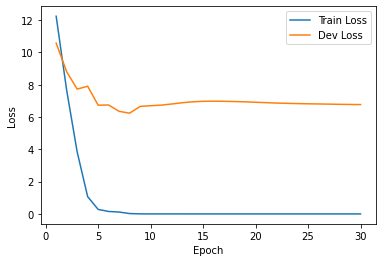

In [34]:
import matplotlib.pyplot as plt

t = list(range(1, 31))
plt.plot(t, train_losses, label="Train Loss")
plt.plot(t, dev_losses, label="Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [35]:
model = torch.load('dump/model.30')
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [39]:
for idx, sample in zip(range(1, 11), sample_ds):
    print(f'------{idx}------')
    
    input_ids, token_type_ids, attention_mask = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids","attention_mask")
    ]
    
    with torch.no_grad():
        start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :], attention_mask=attention_mask[None, :])
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    print(sample['input_ids'].shape)
    answer = sample["input_ids"][int(start) : int(end) + 1]
    print(tokenizer.decode(answer))
    print(start_logits, end_logits)
    
    


    # start = sample['position'][start][0]
    # end = sample['position'][end][1]

   

------1------
torch.Size([512])
이르는
tensor([-7.5908, -8.6982, -8.8808, -8.7660, -9.0423, -8.8141, -9.1434, -9.0241,
        -9.2442, -9.0139, -8.9533, -9.2031, -9.1084, -9.1385, -8.9601, -9.2613,
        -8.6175, -8.5485, -8.6329, -8.8884, -8.2432, -8.9139, -9.0785, -8.8417,
        -8.7770, -8.8617, -9.0721, -9.0217, -9.0884, -9.0392, -8.8062, -8.8649,
        -9.1086, -9.0610, -9.1205, -9.1552, -9.0314, -9.2553, -9.1514, -9.0955,
        -8.8750, -8.6594, -8.2736, -8.9949, -8.4618, -9.1663, -8.8654, -9.1548,
        -9.1051, -8.9640, -8.9792, -8.8815, -8.8658, -8.9528, -8.9553, -8.9092,
        -8.7774, -8.9578, -9.2875, -8.5972, -8.9922, -9.0422, -8.9553, -9.2722,
        -9.0630, -9.4037, -9.2012, -8.9877, -9.0589, -9.1227, -8.9123, -9.1561,
        -8.9410, -8.9117, -9.0632, -9.1918, -8.7280, -8.9478, -9.0211, -8.8823,
        -9.0522, -8.8023, -8.7647, -8.9590, -8.9469, -8.8244, -9.1463, -9.0646,
        -9.0685, -9.0212, -8.8801, -8.7421, -9.0444, -9.0609, -8.9327, -8.9348,
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([-8.4481, -9.1720, -9.4995, -9.1741, -9.1653, -9.3607, -9.3793, -9.2856,
        -9.0141, -9.3446, -9.4085, -9.1273, -8.9229, -9.1583, -9.2211, -9.1161,
        -8.8746, -7.3296, -7.4426, -7.7554, -8.2980, -8.7746, -9.1622, -8.7201,
        -9.1904, -8.8396, -9.4880, -9.7095, -9.5067, -9.4281, -9.1845, -9.3680,
        -9.3165, -9.1179, -8.5817, -8.6186, -8.8254, -9.3122, -8.7633, -9.1441,
        -9.2365, -9.1134, -9.2996, -9.4202, -9.1986, -9.3918, -9.2870, -9.5147,
        -9.5553, -9.3341, -9.4973, -9.5557, -9.4296, -9.3872, -9.6593, -9.4831,
        -9.3915, -9.4843, -9.2856, -9.5371, -9.4979, -9.3859, -9.3644, -8.6142,
        -8.9570, -9.0801, -9.2356, -9.4489, -9.4349, -9.4986, -9.3391, -9.1002,
        -8.9560, -9.1847, -8.7388, -9.0117, -9.4287, -9.3447, -9.5550, -9.6508,
        -9.3775, -9.5581, -9.5114, -9.3889, -9.2302, -9.4720, -9.4541, -9.5407,
        -9.3546, -9.3297, -9.1066, -8.7028, -7.6901, -7.8781, -8.6913, -9.0133,
        -9.1595, -9.1587, -9.3529, -9.16

In [40]:
test_dataset = KoMRC.load('/content/test.json')
test_dataset = TKIndexerWrappedDataset(test_dataset, tokenizer)
print("Number of Test Samples", len(test_dataset))
print(test_dataset[0])

4008


100%|██████████| 5341/5341 [00:00<00:00, 17308.35it/s]

Number of Test Samples 5341
{'input_ids': tensor([    2, 22917, 28206, 17216, 14522, 37421, 16160, 27025,  8078,  2033,
            3, 22496, 22354,  2010, 14388, 32124,  8175,  2011,  3052, 29368,
        14702, 29217, 16022, 13975,     1, 22496, 22354, 14702, 19493, 27025,
            1,  5887, 17280, 26526, 13980, 14875,  2016, 14099, 22496, 22354,
        14702, 19493, 27025,  2010, 16510, 14702, 19493, 27025,  2011,  5883,
        22496, 25672, 15142,  8061, 25264, 15142,  2014, 23117, 15142,  2014,
        23507, 15142,  6677, 33886,  2014, 21420, 23973, 14856, 17101,  2014,
        22496, 18308, 14670, 15525, 28491,  4345, 13979,  7747, 15683,  8038,
        18666,  6540, 17666, 14937,  8734, 29453,  8112, 33184,  5226, 17426,
        33295, 36886, 29014, 23160, 36044,  2016, 14336,  3033, 35898,  8129,
         4340,  3033, 35898,  8167, 14702, 19493, 27025,  8078,  7328, 37997,
        14117,  5684, 20875,  8266, 15701,  2010, 32362, 17280,  2011, 14681,
        21089,  8122, 

In [101]:
import csv


os.makedirs('out', exist_ok=True)
with torch.no_grad(), open('out/baseline.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    for sample in tqdm(test_dataset, "Testing"):

        input_ids, token_type_ids, attention_mask = [
            torch.tensor(sample[key], dtype=torch.long, device="cuda")
            for key in ("input_ids", "token_type_ids","attention_mask")
        ]
        
        with torch.no_grad():
            start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :], attention_mask=attention_mask[None, :])
        start_logits.squeeze_(0), end_logits.squeeze_(0)
        
        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

        if probability.numel() :
          index = torch.argmax(probability).item()
            
          start = index // len(end_prob)
          end = index % len(end_prob)
          
          answer = sample["input_ids"][int(start) : int(end) + 1]
          last_answer = tokenizer.decode(answer)
          rows.append([sample["guid"], last_answer])


          # input_ids, token_type_ids = [
          #     torch.tensor(sample[key], dtype=torch.long, device="cuda")
          #     for key in ("input_ids", "token_type_ids")
          # ]
      
          # with torch.no_grad():
          #     start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
          # start_logits.squeeze_(0), end_logits.squeeze_(0)
      
          # start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
          # end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
          # probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
          # index = torch.argmax(probability).item()
      
          # start = index // len(end_prob)
          # end = index % len(end_prob)
      
          # start = sample['position'][start][0]
          # end = sample['position'][end][1]

          # rows.append([sample["guid"], sample['context'][start:end]])
    
    writer.writerows(rows)

Testing:   0%|          | 0/5341 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Testing: 100%|██████████| 5341/5341 [03:35<00:00, 24.80it/s]
